# Model Interpretation

We now have a model that can predict mile per gallon for a car with an __RMSE of 2.27 MPG__.

We will assume that this prediction is accurate enough. 

Model interpretation is the last step of our machine learning project. We will try to understand how the model is making its predictions by looking, for example, at features importance and at a single tree from the random forest.


### Results from this notebook
- According to the random forest model, the size of the engine and the weight of the car are the most importante features to predict MPG. This is in line with the findings from EDA. The features `weight` and `displacement` have the highest correlation scores. 

In [1]:
# use black formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# reload module in development mode
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
# save the figures

import os

root_dir = ".."
ml_step = "interpretation"
fig_path = os.path.join(root_dir, "figures", ml_step)
os.makedirs(fig_path, exist_ok=True)

from src.utils import save_fig

<IPython.core.display.Javascript object>

#### Load trained model

In [4]:
import pickle

pkl_filename = "../models/pickle_random_forest.pkl"
with open(pkl_filename, "rb") as file:
    rf_tuned = pickle.load(file)

<IPython.core.display.Javascript object>

#### Load test sets

In [5]:
import pandas as pd
from src.utils import split_features_target

df_test = pd.read_pickle("../data/processed/test_processed.pkl")
X_test, y_test = split_features_target(df_test, "mpg")

print("test set shape:", df_test.shape)

test set shape: (80, 9)


<IPython.core.display.Javascript object>

#### Imports for vizualisation

In [6]:
# Imports for vizualisation
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns

sns.set(font_scale=1.3)
# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

<IPython.core.display.Javascript object>

## Feature importance 

A nice tool offered by the random forest algorithm is its capacity to measure the relative importance of features. 

For a given feature, it computes the decrese in impurity that result from spliting a set of intances in two using this feature. This is measured accross all tree nodes using this feature to split the data.

Then it averages this measure across all trees in the forest.

#### Plot feature importance

Saving figure feature_importance


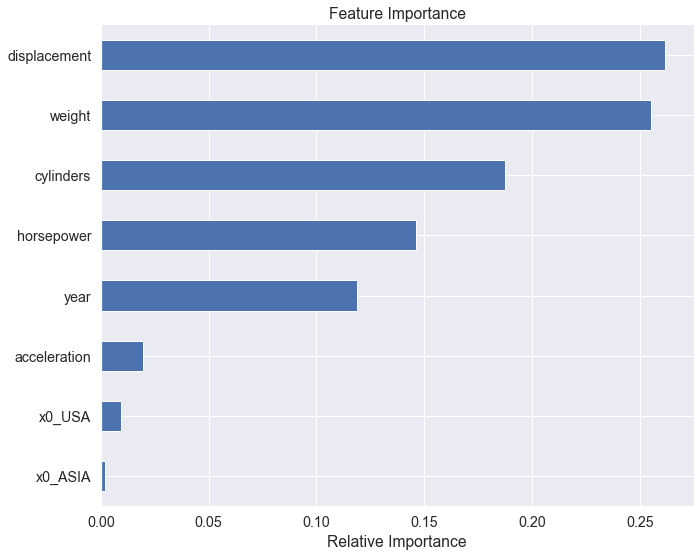

<IPython.core.display.Javascript object>

In [7]:
figsize(10, 8)
feat_importances = pd.Series(rf_tuned.feature_importances_, index=X_test.columns)
feat_importances.sort_values().plot(kind="barh")
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
sns.despine()
save_fig(fig_path, "feature_importance")

- According to our random forest model, the most predictive feature of a car MPG is `displacement`, closely followed by `weight`. From EDA the most correlated feature was `weight`. 
Displacement describes the size of the car engine. From our exploratiy data analysis (cf. notebook 2), we know also know that `displacement` and `weight` features have a high correlation score.
They might carry redundant information. A heavy car is likely to have a bigger engine.

We can try to drop one of these features and see if it penalises the performance of the model. If it does not, we can get rid of it for the sake of model simplicity. We will keep it for now. For this case, the original set of features is small enough to be easily interpreted and the training and prediction time is not a concern. 

- The features about the origin of the cars (`x0_USA`, `x0_ASIA`) have little importance in predicting MPG.

Another good experiment would be to drop them and see if it improves the model scores.

In our case, the total number of features is small enough to be easily interpreted and the training and prediction time is not a concern. 

## Looking at a single tree

A random forest is an ensemble of multiple desicion trees. In Sklearn the prediction is made by averaging the predictions of all trees (100 for our random forest model).

It's hard to understand how a prediction is made for a random forest, which why we call them black boxe models. However, we can still look at one of these trees, even if it's not representative of all trees, to get a feeling of how a single tree is making its prediction. 

In [8]:
single_tree = rf_tuned.estimators_[0]

<IPython.core.display.Javascript object>

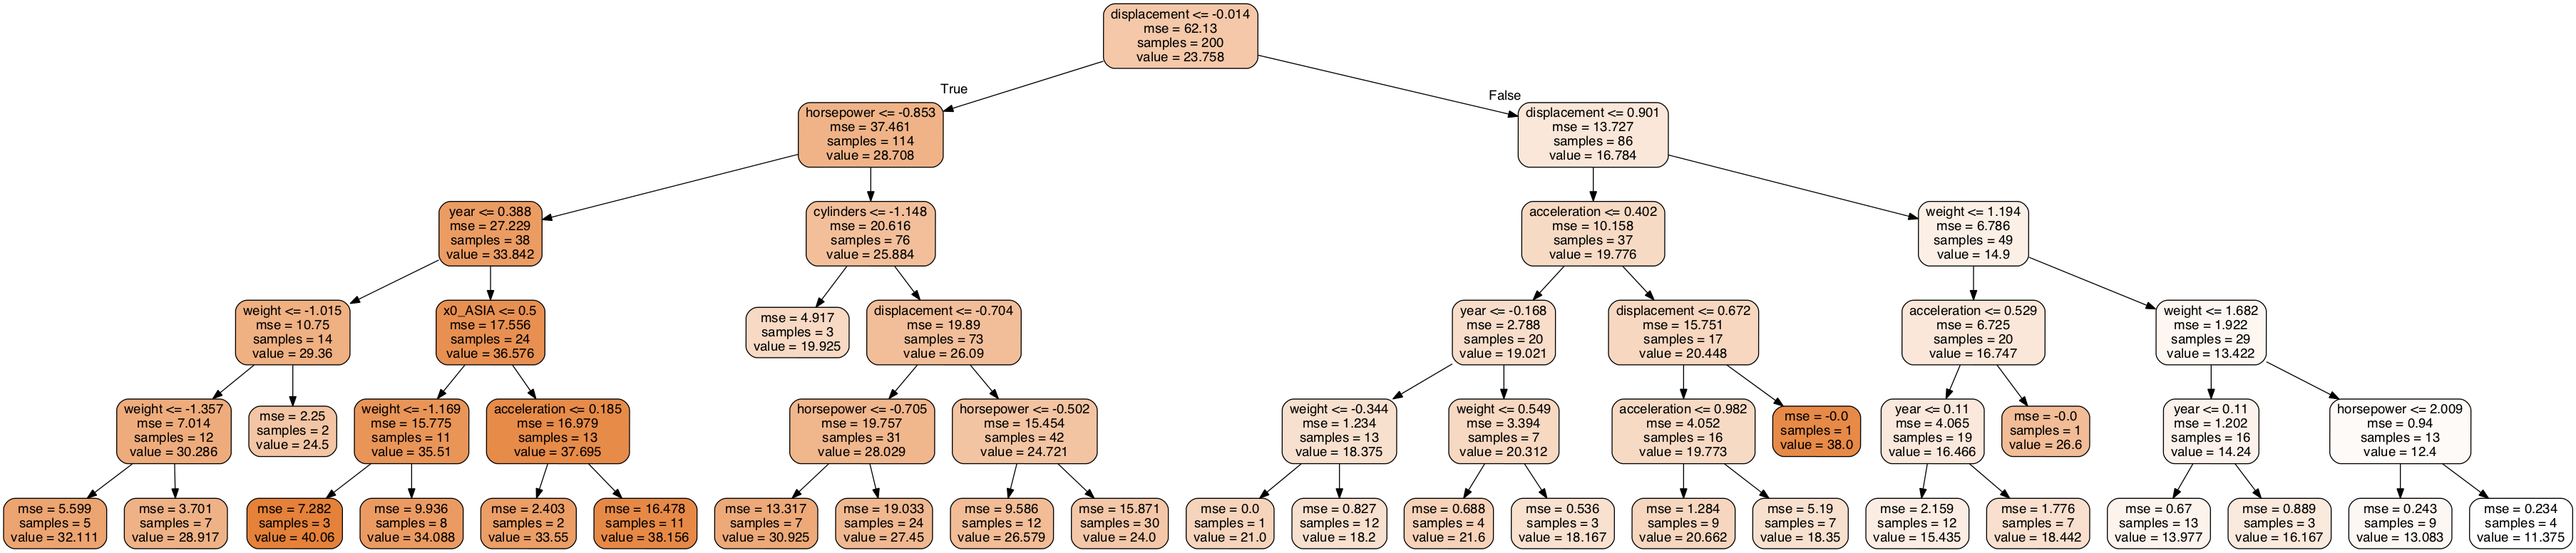

<IPython.core.display.Javascript object>

In [9]:
from sklearn.tree import export_graphviz
from IPython.display import Image

out_file = os.path.join(fig_path, "single_tree.dot")

export_graphviz(
    single_tree,
    feature_names=X_test.columns,
    out_file=out_file,
    rounded=True,
    filled=True,
)

# convert the image to png
!dot -Tpng ../figures/interpretation/single_tree.dot -o ../figures/interpretation/single_tree.png 

Image(filename=os.path.join(fig_path, "single_tree.png"))

The tree has a maximum depth of 5. Let's limit the diplayed dapth to 3.

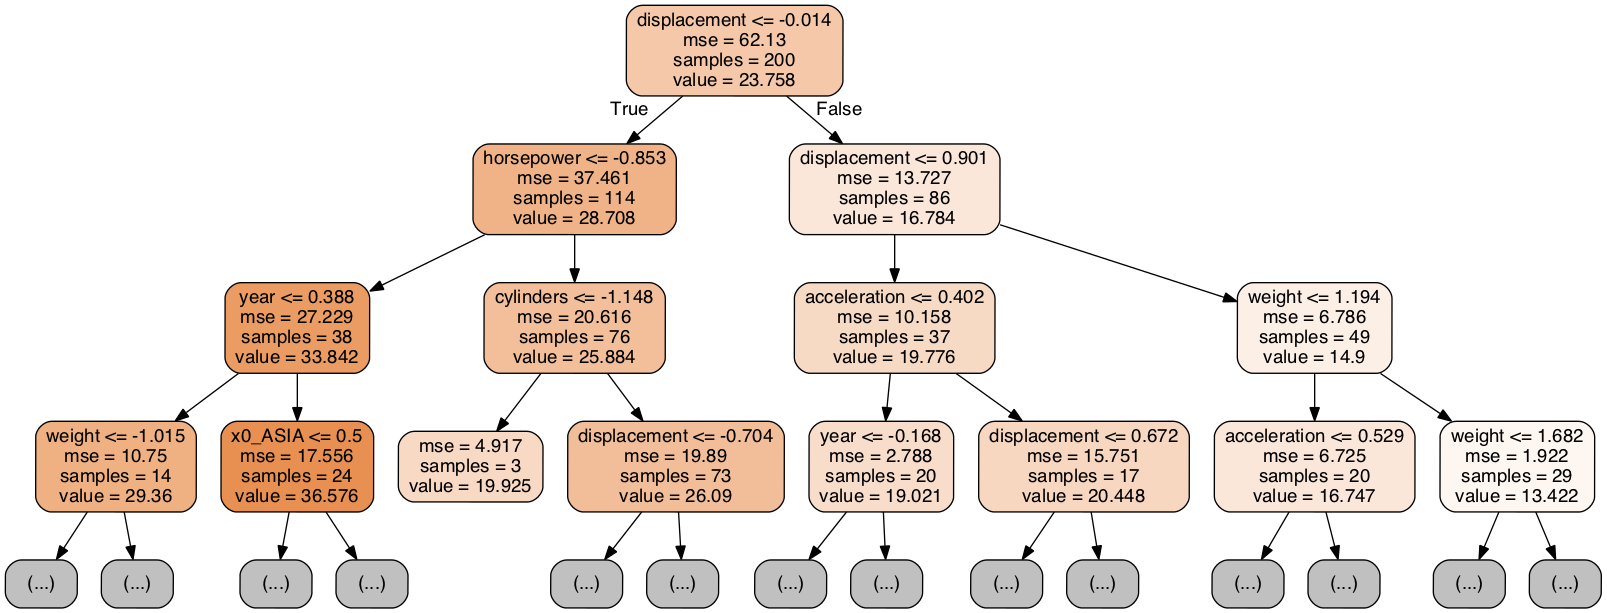

<IPython.core.display.Javascript object>

In [10]:
out_file_dot = os.path.join(fig_path, "single_tree_depth_3.dot")

export_graphviz(
    single_tree,
    feature_names=X_test.columns,
    out_file=out_file_dot,
    rounded=True,
    filled=True,
    max_depth=3,
)

# convert the image to png
!dot -Tpng ../figures/interpretation/single_tree_depth_3.dot -o ../figures/interpretation/single_tree_depth_3.png 

Image(filename=os.path.join(fig_path, "single_tree_depth_3.png"))

Each node has four components:
- the feature that it splits the data based on a cutoff value
- `value` is the predicted value for instances that belongs to the node. For the top node (also called the root), `value` equals the mean MPG for the training set minus the validation set (we used cross-validation to train the model).
- `samples` is the number of instances in the node.
- `mse` is the mean squared error of prediction where the prediction is the mean of the samples


Now, let's try to interpret this decision tree model. The tree works like a yes/no flow chart starting from the root. To make its prediction on a given instance, the model looks at `displacement`, check if it iss less or equal to -0.014. If the answer is yes, the model checks `horsepower`. Is it less or equal to -0.853? it the answer is yes, it moves on to check `year`. The model goes on iteratively until it reached the bottom of the tree which is a leaf node and returns its value for the prediction. 

In the following code, we look at the predictions given by the selected tree and by the whole forest for a single instance. 

In [11]:
import numpy as np


def single_instance_predictions(n):
    # features of the instance n
    x_n = np.array(X_test.loc[n]).reshape(1, -1)
    # prediction for instance n by the singnle tree
    y_n_pred_tree = single_tree.predict(x_n)[0]
    # prediction for instance n by the forest
    y_n_pred_forest = rf_tuned.predict(x_n)[0]

    print("Predictions for Instance", n)
    print("Predicted value by decision tree: {:.2f}".format(y_n_pred_tree))
    print("Predicted value by random forest: {:.2f}".format(y_n_pred_forest))
    print("Measured value: {:.2f}".format(y_test[n]))


single_instance_predictions(50)

Predictions for Instance 50
Predicted value by decision tree: 26.58
Predicted value by random forest: 24.56
Measured value: 22.00


<IPython.core.display.Javascript object>

For the instance 50, the random forest is more accurante than the decision tree.

In [12]:
single_instance_predictions(0)

Predictions for Instance 0
Predicted value by decision tree: 32.11
Predicted value by random forest: 31.64
Measured value: 33.00


<IPython.core.display.Javascript object>

For the instance 0 the random forest is less accurate than the decison tree.

Let's now look at the RMSE of the single decision tree and compared to the RMSE of the random forest.

In [13]:
from sklearn.metrics import mean_squared_error

y_pred_tree = single_tree.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print("RMSE decision tree: {:.2f}".format(rmse_tree))

y_pred_forest = rf_tuned.predict(X_test)
rmse_forest = np.sqrt(mean_squared_error(y_test, y_pred_forest))
print("RMSE random forest: {:.2f}".format(rmse_forest))

RMSE decision tree: 3.21
RMSE random forest: 2.27


<IPython.core.display.Javascript object>

As we expected, the random forest outperforms a single decision tree. This is what is great about ensembles of trees! Aggregating an ensemble of weak learners leads to better performance. Ensembling is also a good way to address the high variance of decision tree models: they are very sensitive to small changes in the training set. This is well explained in [Hands on Machine Learning](http://shop.oreilly.com/product/0636920142874.do) by Aurélien Géron

The goal is not to look at each one of the trees (100 in total). Examining a single tree is still a good way to understand what is going on under the hood of the forest. 


## Locally Interpretable Model-agnostic Explanations (LIME) 

We can go further and use [LIME](https://arxiv.org/pdf/1602.04938.pdf) a relatively new method (2016) for model interpretation.
The main idea of LIME is to use a linear model to learn the errors and explains why the model is making these errors. 